# In this project we will try to predict the price of Boston houses using machine learning. This notebook was developed on AWS Sagemaker.

# 1/ Setup

Load some required packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
import sklearn.model_selection
import warnings
warnings.filterwarnings("ignore")
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sklearn.metrics import mean_squared_error


In [2]:
# Set up the environment in SageMaker
session = sagemaker.Session()
role = get_execution_role()

In [3]:
# We can load the dataset Boston directly from Sklearn 
df = load_boston()
X = pd.DataFrame(df.data, columns=df.feature_names)
Y = pd.DataFrame(df.target)

In [5]:
# Look at the top 5 observations
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


# 2/ Data exploration

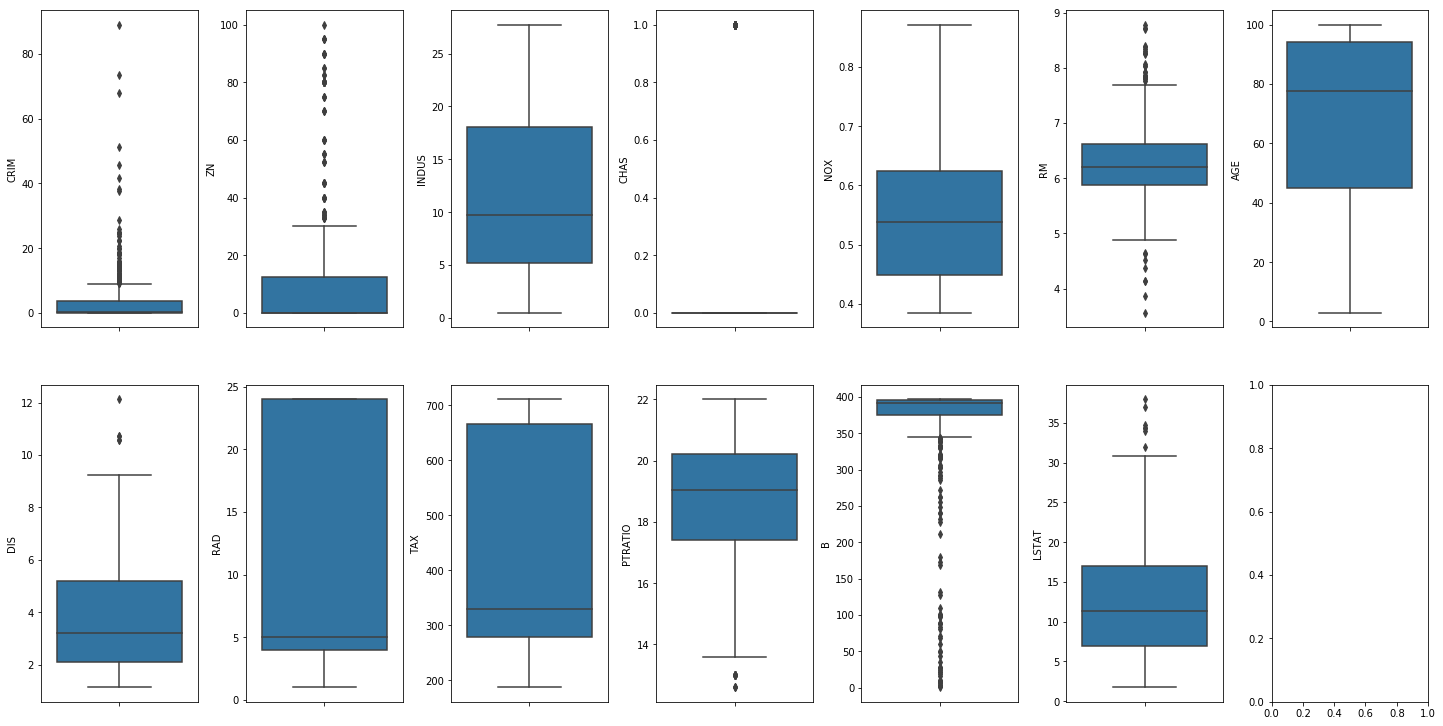

In [6]:
# Explore the distribution of our features
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in X.items():
    sns.boxplot(y=k, data=X, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Some columns like CRIM, RM and B may have outliers. For now, we can leave them in the dataset. We may deal with them later.

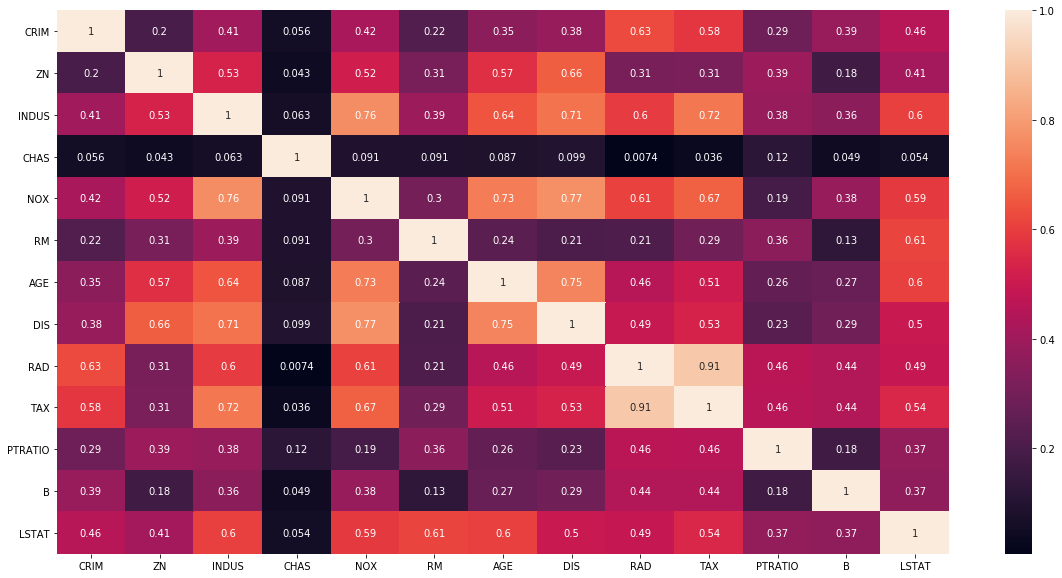

In [7]:
# Measure the correlations between features
plt.figure(figsize=(20, 10))
sns.heatmap(X.corr().abs(),  annot=True)

We can see that TAX and RAD are highly correlated. There are also other pairs of features that have medium correlations. As a result, we will use a tree-based model which is able to handle correlated features.

About our response variable, we can see that the distribution of house price is quite bell-shaped, which is what we expect. There seems to be a second small mode near the value 50 but overall the density curve does not deviate too much from the normal density.

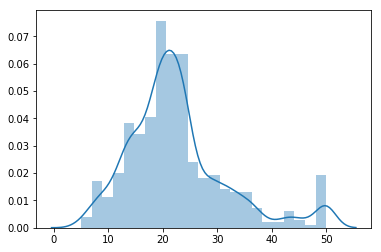

In [8]:
# Let's see the distribution of the response variable (house price)
sns.distplot(Y)

# 3/ Model fitting and deploying

We will upload our data to S3, AWS' storage service, to train our model on Sagemaker. First we need to split the data into trai, validation and test sets first.

In [10]:
# Get local directory
data_dir = '../data/boston'

# Split data into train, validation and test sets
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.33)
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

Now we save these datasets and upload them to S3.

In [11]:
# Save them locally
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)
pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

In [16]:
# Upload to S3
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'))
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'))
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'))

Now we are ready to train Xgboosst model, which comes with Sagemaker, on our data on S3.

In [17]:
container = get_image_uri(session.boto_region_name, 'xgboost')
# Set up our estimator
xgb = sagemaker.estimator.Estimator(container, role, train_instance_count=1, train_instance_type='ml.m4.xlarge', 
                                    output_path='s3://{}/output'.format(session.default_bucket()),
                                    sagemaker_session=session)
# Choose the hyperparameters
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

	get_image_uri(region, 'xgboost', 0.90-1).


In [19]:
# Feed the train and validation sets to the model and start training
train_channel = sagemaker.s3_input(s3_data=train_location, content_type='csv')
valid_channel = sagemaker.s3_input(s3_data=val_location, content_type='csv')

data_channels = {'train': train_channel, 'validation': valid_channel}
xgb.fit(inputs=data_channels,  logs=True)

2019-08-25 19:46:55 Starting - Starting the training job...
2019-08-25 19:46:57 Starting - Launching requested ML instances......
2019-08-25 19:47:59 Starting - Preparing the instances for training...
2019-08-25 19:48:54 Downloading - Downloading input data...
2019-08-25 19:49:16 Training - Downloading the training image..
Arguments: train
[2019-08-25:19:49:35:INFO] Running standalone xgboost training.
[2019-08-25:19:49:35:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8596.1mb
[2019-08-25:19:49:35:INFO] Determined delimiter of CSV input is ','
[19:49:35] S3DistributionType set as FullyReplicated
[19:49:35] 227x13 matrix with 2951 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-08-25:19:49:35:INFO] Determined delimiter of CSV input is ','
[19:49:35] S3DistributionType set as FullyReplicated
[19:49:35] 112x13 matrix with 1456 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&

After our model finished training, we need to deploy it to make predictions. Sagemaker makes deploying models extremely easy. Since we want to use our models to make predictions on the whole test set, we will initialize a batch trasnform job.  

In [21]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge',output_path = test_location)
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer.wait()

.........................................!


We can take the predictions from S3 and save them locally using the command below: 

In [22]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir


download: s3://sagemaker-us-west-2-544494197435/data/test.csv/test.csv.out to ../data/boston/test.csv.out


# 4/ Model evaluation

Now let's look at the ranking of feature importance. Sagemaker does not support viewing feature importance directly so we have to do it locally. First let's install xgboost locally.

In [43]:
!conda install -y -c conda-forge xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    libxgboost-0.90            |       he1b5a44_2         2.4 MB  conda-forge
    py-xgboost-0.90            |   py36he1b5a44_2          73 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    xgboost-0.90               |   py36he1b5a44_2          11 KB  conda-forge
    -------------------------------------------------

Now get the importance scores for each feature.

In [44]:
import s3fs
import pickle
import tarfile
import xgboost

model_path = 's3://second9627/output/xgboost-2019-08-25-20-22-37-852/output/model.tar.gz'

fs = s3fs.S3FileSystem()

with fs.open(model_path, 'rb') as f:
    with tarfile.open(fileobj=f, mode='r') as tar_f:
        with tar_f.extractfile('xgboost-model') as extracted_f:
            xgbooster = pickle.load(extracted_f)

temxgbooster.get_fscore()

[20:59:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'f5': 192,
 'f12': 162,
 'f0': 327,
 'f7': 105,
 'f11': 111,
 'f4': 97,
 'f10': 50,
 'f2': 42,
 'f9': 39,
 'f8': 23,
 'f1': 23,
 'f6': 137,
 'f3': 8}

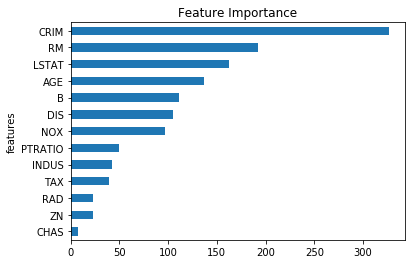

In [58]:
# Plot them
features = X.columns
importance=np.array([0]*len(features))
for item in temp:
    num = item[1:]
    importance[int(num)] = temp[item]
feature_importance = pd.DataFrame({ 'features': features ,'score': importance}).sort_values('score')
feature_importance.plot.barh(x='features',title='Feature Importance',legend=False)

We can see that CRIM (crime rate) is extremely important in determining the price of a house. The next 3 most important predictors are RM (number of rooms per dwelling), LSTAT (% lower status of the population) and AGE (proportion of owner-occupied units built prior to 1940). I think these top predictors agree with our intuition about what affect house prices.

Now let's see the performance of our model on the test set

In [23]:
# Load our model's predictions
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)


Text(0.5, 1.0, 'Median Price vs Predicted Price')

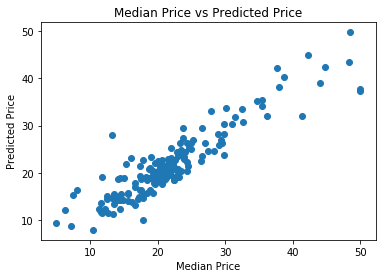

In [24]:
# Visualize the predictions vs the true values
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

Most of the points lie very closely to the diagonal line, which is what we want. There are some deviations here and there but overall the result is satisfactory. Let's see the MSE

In [25]:
mean_squared_error(Y_test,Y_pred)

10.839766754051848

The MSE is around 10.8, not too bad. Further improvements can be achieved by tuning the Xgboost model or by dropping the least important predictors.